### Galaxy-Flux correlation in bins of K

In [14]:
import numpy as np
from astropy.table import Table
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import treecorr
import matplotlib.pyplot as plt


def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    from get_masks import get_milkyway_mask

    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458  # km/s
    chunksize = 200_000

    # Read header
    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
        filename,
        delim_whitespace=True,
        names=header,
        usecols=cols_to_use,
        skiprows=1,
        chunksize=chunksize
    ):
        
        # Exclude entries with no redshift
        chunk = chunk[chunk["dist_flag"] != 0]

        # Compute cz
        chunk["cz"] = c * chunk["z_cmb"]

        # Apply the main physical filters
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]

        # Compute absolute K magnitude
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25

        # Apply isfinite mask *inside the loop*
        mask = np.isfinite(chunk["M_K"]) & np.isfinite(chunk["d_L"])
        chunk = chunk.loc[mask]

        # Append filtered data
        filtered_chunks.append(chunk)

    # Concatenate everything
    df = pd.concat(filtered_chunks, ignore_index=True)
    # Compute absolute K magnitude
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]
    df = df[df['Dec']<45.]

    print(f"Remaining galaxies after all cuts: {len(df)}")

    return df

def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    from get_masks import get_milkyway_mask

    # Generate random RA and Dec within specified declination limits
    rand_ra = np.random.uniform(0, 360, N_total*3)
    rand_sindec = np.random.uniform(
        np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total*3
    )
    rand_dec = np.degrees(np.arcsin(rand_sindec))

    # Apply Milky Way mask
    mask = get_milkyway_mask(rand_ra, rand_dec)
    rand_ra = rand_ra[mask][:N_total]
    rand_dec = rand_dec[mask][:N_total]
    if len(rand_ra) < N_total:
        raise ValueError(f"Not enough random points generated: {len(rand_ra)} < {N_total}")

    return rand_ra, rand_dec

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "num_bootstrap": 200,
    "cross_patch_weight": 'geom'
}

"""
READ DATA
"""
# === Load galaxy catalogue ===
cols = [
    "GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"
]
gxs = read_GLADE(cols)

# === Load flux catalog ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg', npatch=20)


/tmp/ipykernel_10328/1251932582.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978


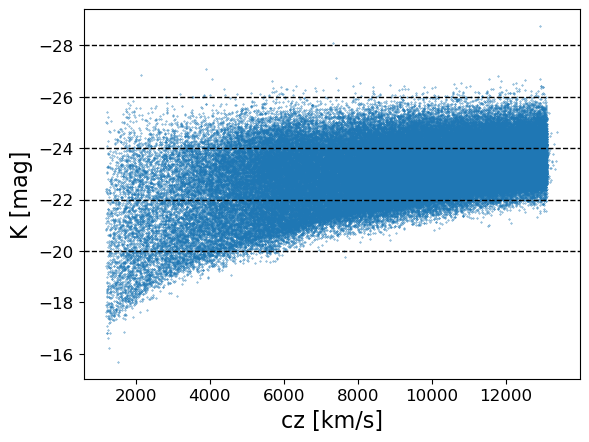

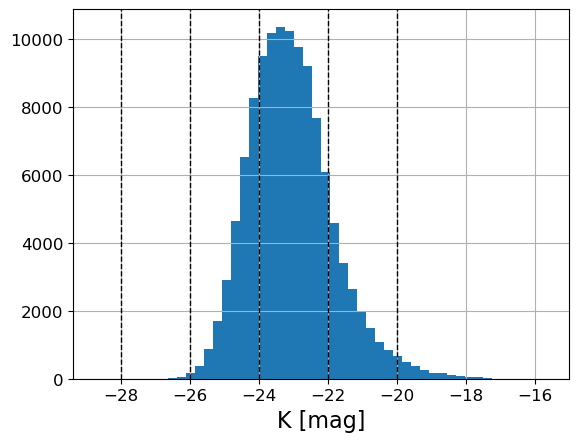

In [15]:
plt.scatter(gxs['cz'], gxs['M_K'], s=.1)
plt.xlabel('cz [km/s]')
plt.ylabel('K [mag]')
for K in [-20, -22, -24, -26, -28]:
    plt.axhline(K, color='k', ls='--', lw=1)
plt.axhline
plt.gca().invert_yaxis()
#plt.grid()
plt.show()

plt.hist(gxs['M_K'], bins=50, color='C0')
for K in [-20, -22, -24, -26, -28]:
    plt.axvline(K, color='k', ls='--', lw=1)
plt.xlabel('K [mag]')
plt.grid()
plt.show()

Processing slice: -22 -20
N. of galaxies in slice: 17224
Processing slice: -24 -22
N. of galaxies in slice: 70458
Processing slice: -26 -24
N. of galaxies in slice: 27014
Processing slice: -28 -26
N. of galaxies in slice: 151
The following patch numbers have no objects: {11}
This may be a problem depending on your use case.
The following patch numbers have no objects: {11}
This may be a problem depending on your use case.


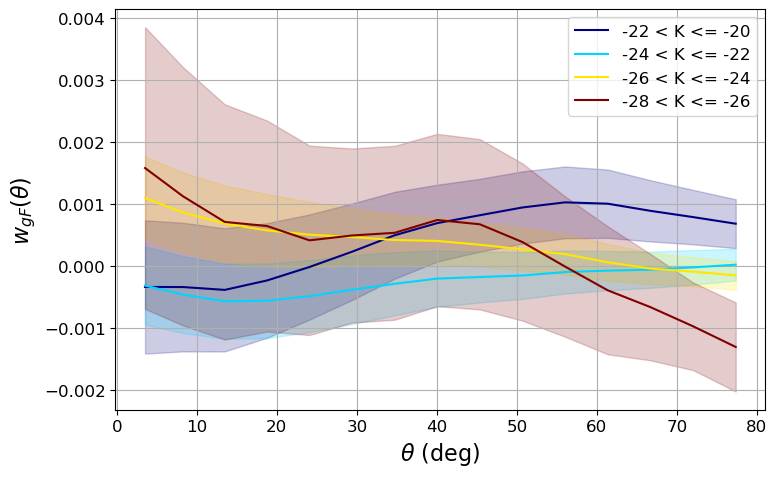

In [16]:

"""
CALCULATE CORRELATIONS FOR CZ SLICES
"""
k_slices = [(-20,-22), (-22,-24), (-24,-26), (-26,-28)]
colors = plt.cm.jet(np.linspace(0, 1, len(k_slices)))  # Color gradient

fig, ax = plt.subplots(figsize=(8, 5))

for i, (k_max, k_min) in enumerate(k_slices):

    print('Processing slice:', k_min, k_max)

    # Filter galaxies for the current cz slice
    gxs_slice = gxs[(gxs['M_K'] > k_min) & (gxs['M_K'] <= k_max)]

    print('N. of galaxies in slice:', len(gxs_slice))

    # Generate random catalog for the current slice
    rand_ra, rand_dec = generate_RanCat(len(gxs_slice)*10, dec_min=-90, dec_max=45)

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(ra=gxs_slice['RA'], dec=gxs_slice['Dec'],
                                  ra_units='deg', dec_units='deg', npatch=20)
    rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, 
                                ra_units='deg', dec_units='deg', patch_centers=gcat_slice.patch_centers)

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    xi, varxi = nk.calculateXi(rk=rk)

    xi = xi / flux_val.mean()  # Normalize by mean flux value
    # Plot with color gradient
    # plt.errorbar(nk.meanr, xi/flux_val.mean(), yerr=varxi**.5, fmt='o-', color=colors[i],
    #              label=f'{cz_min} < cz <= {cz_max}')
    plt.fill_between(nk.meanr, xi - varxi**0.5, xi + varxi**0.5, 
                     color=colors[i], alpha=0.2)  # Add error band
    plt.plot(nk.meanr, xi, color=colors[i], label=f'{k_min} < K <= {k_max}')

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 16,     # x/y labels
    'axes.titlesize': 18,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})

# Add colorbar using a dummy ScalarMappable
# norm = plt.Normalize(vmin=cz_slices[0][0], vmax=cz_slices[-1][1])
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm.set_array([])  # dummy array
# cbar = fig.colorbar(sm, ax=ax)
# cbar.set_label('cz range')

# Finalize plot
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$w_{gF}(\theta)$')
ax.grid()
ax.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('gal_flux_correlation.png', dpi=300)  # Save the figure
plt.show()

### Low K gxs have more correlation with flux, but there is a bias with cz 

/tmp/ipykernel_10328/1251932582.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978
-20
-23
-26


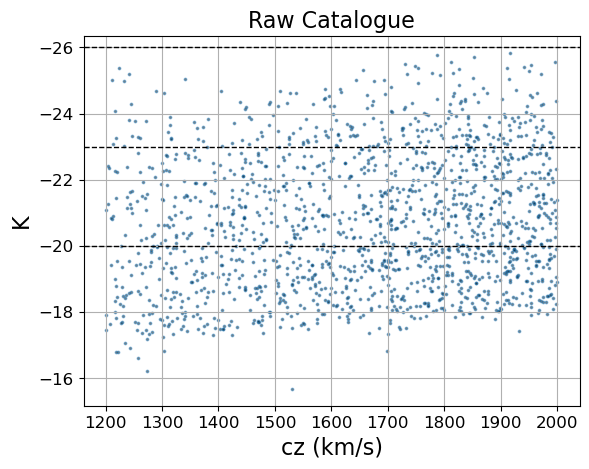

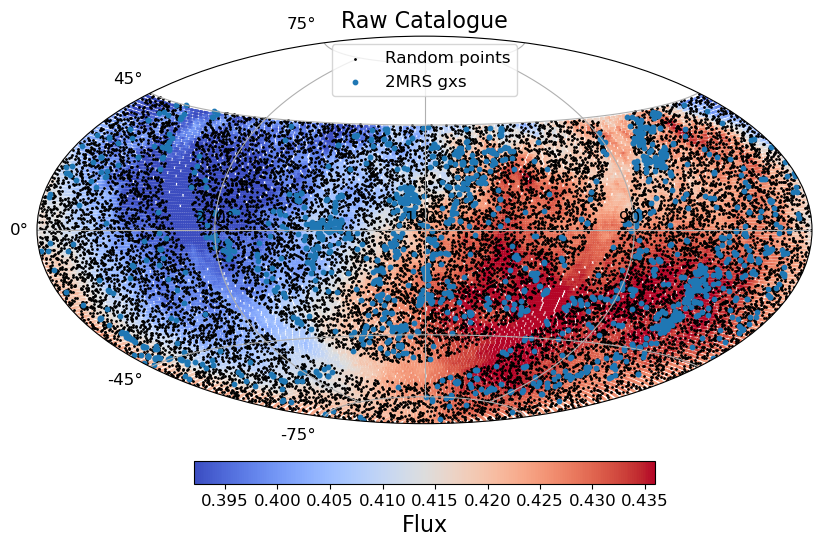

Processing slice: -21 -20
Processing slice: -26 -23


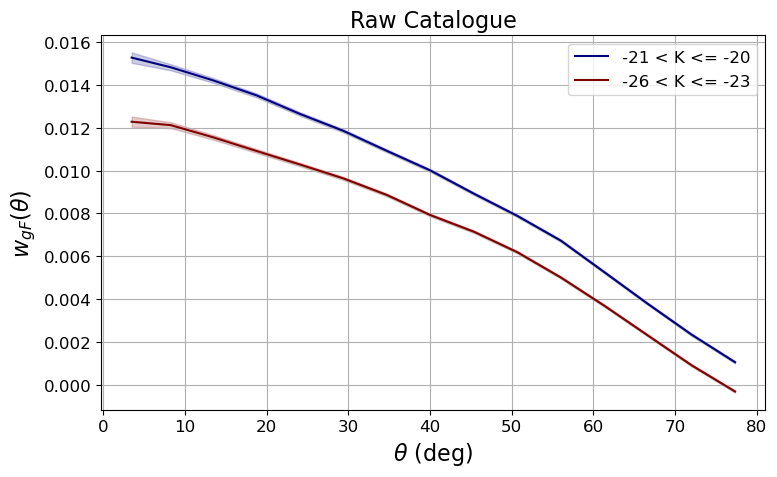

In [17]:
"""
CALCULATE CORRELATIONS FOR K SLICES WITH CZ CUT
"""
# === Load Galaxies ===
gxs = read_GLADE(cols)
k_slices = [(-20, -21), (-23,-26)]
colors_kslices = plt.cm.jet(np.linspace(0, 1, len(k_slices)))  # Color gradient

gxs_K = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 2000)]  # Apply cz cut to galaxy catalog

# === Load Flux map ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg')#, npatch=10)

# Generate random catalog for the current slice
rand_ra, rand_dec = generate_RanCat(len(gxs_K)*10, dec_min=-90, dec_max=45)

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    #"var_method": 'bootstrap',
    #"num_bootstrap": 500,
    "cross_patch_weight": 'geom'
}

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 16,     # x/y labels
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})
#################
#################
# Plot K vs CZ
#################
#################
plt.scatter(gxs_K['cz'], gxs_K['M_K'], s=3, color='C0', alpha=0.5, label='K vs cz', facecolor='k')
for K in [item[0] for item in k_slices] + [k_slices[-1][1]]:
    print(K)
    plt.axhline(K, color='k', ls='--', lw=1)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('cz (km/s)')
plt.ylabel('K')
plt.title('Raw Catalogue')
plt.show()

#################
#################
# Plot SkyMap
#################
#################
from matplotlib import colors

# === Plot ===
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

# Set ticks
xticks_deg = [270, 180, 90]
xticks_rad = -np.radians(xticks_deg) + np.pi
ax.set_xticks(xticks_rad)
ax.set_xticklabels([f"{d}°" for d in xticks_deg])

yticks_deg = [-75, -45, 0, 45, 75]
yticks_rad = np.radians(yticks_deg)
ax.set_yticks(yticks_rad)
ax.set_yticklabels([f"{d}°" for d in yticks_deg])

# === Flux Scatter plot (with horizontal colorbar below) ===
norm_flux = colors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
sc = ax.scatter(np.deg2rad(-flux_ra+180.), np.deg2rad(flux_dec), c=flux_val, s=5, cmap='coolwarm', norm=norm_flux, edgecolor='none')

# Horizontal colorbar for Flux
cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, fraction=0.05)
cbar_flux.set_label("Flux")

ax.scatter(np.deg2rad(-rand_ra+180.), np.deg2rad(rand_dec), s=1, color='k', label='Random points')
ax.scatter(np.deg2rad(-gxs_K['RA']+180.), np.deg2rad(gxs_K['Dec']), s=10, color='C0', label='2MRS gxs')
plt.legend()
plt.title('Raw Catalogue')
plt.show()

######################
######################
# Plot Correlations
######################
######################
fig, ax = plt.subplots(figsize=(8, 5))
for i, (k_max, k_min) in enumerate(k_slices):

    print('Processing slice:', k_min, k_max)

    # Filter galaxies for the current cz slice
    gxs_slice = gxs_K[(gxs_K['M_K'] > k_min) & (gxs_K['M_K'] <= k_max)]

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(ra=gxs_slice['RA'], dec=gxs_slice['Dec'],
                                  ra_units='deg', dec_units='deg')#, npatch=10)
    rand_cat = treecorr.Catalog(ra=rand_ra[:len(gxs_slice)*10], dec=rand_dec[:len(gxs_slice)*10], 
                                ra_units='deg', dec_units='deg')#, patch_centers=gcat_slice.patch_centers)

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    xi, varxi = nk.calculateXi(rk=rk)
    xi /= flux_val.mean()  # Normalize by mean flux value
    varxi = varxi / (flux_val.mean()**2)

    plt.fill_between(nk.meanr, xi - (varxi**0.5), xi + (varxi**0.5), 
                     color=colors_kslices[i], alpha=0.2)  # Add error band
    plt.plot(nk.meanr, xi, color=colors_kslices[i], label=f'{k_min} < K <= {k_max}')

# Finalize plot
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$w_{gF}(\theta)$')
ax.grid()
ax.legend(loc='upper right')
plt.title('Raw Catalogue')
plt.tight_layout()
#plt.savefig('gal_flux_correlation.png', dpi=300)  # Save the figure
plt.show()

#### Just want to check controlled catalogue

-21
-23
-26


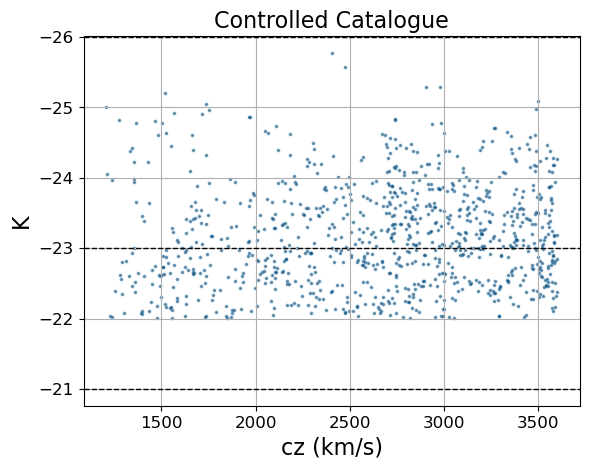

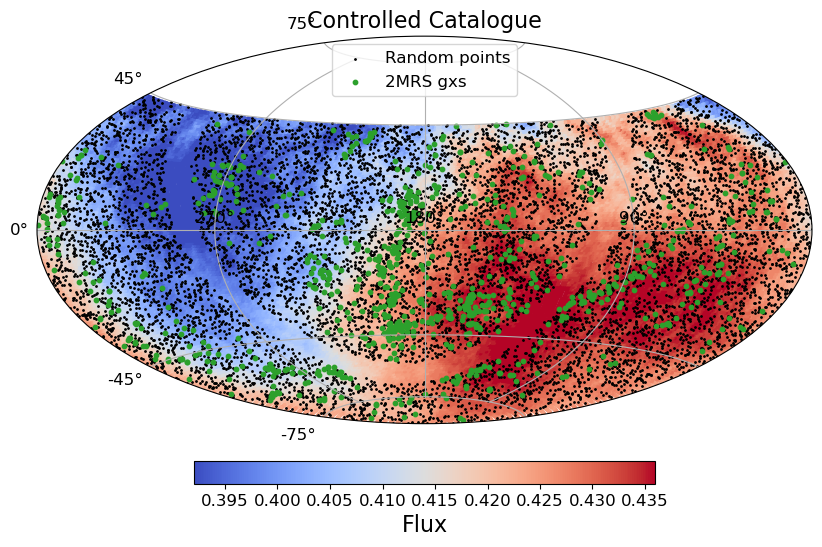

Processing slice: -23 -21
[0.00885241 0.00889934 0.00864751 0.00832607 0.00794462 0.00765502
 0.00730962 0.00694256 0.00647054 0.00574953 0.00483743 0.00387649
 0.00297472 0.00206556 0.00130068] [9.40601221e-06 8.42897619e-06 7.69675731e-06 7.13421291e-06
 6.88873531e-06 6.76991353e-06 6.70206969e-06 6.56748822e-06
 6.38024998e-06 6.23500933e-06 6.28668501e-06 6.43382594e-06
 6.46760231e-06 6.32029476e-06 6.19278783e-06]
Processing slice: -26 -23
[ 1.10691831e-02  1.09812838e-02  1.07043694e-02  1.02689448e-02
  9.83398672e-03  9.23862789e-03  8.62764915e-03  7.98204860e-03
  7.20717483e-03  6.17778327e-03  5.11941257e-03  3.78959166e-03
  2.39164030e-03  1.07988498e-03 -5.85779648e-06] [1.13924540e-05 1.06299502e-05 9.92936416e-06 9.26400055e-06
 8.86141454e-06 8.65116150e-06 8.51941432e-06 8.44018608e-06
 8.26124725e-06 8.16082940e-06 7.99890242e-06 7.72798622e-06
 7.36621796e-06 6.88711799e-06 6.57084035e-06]


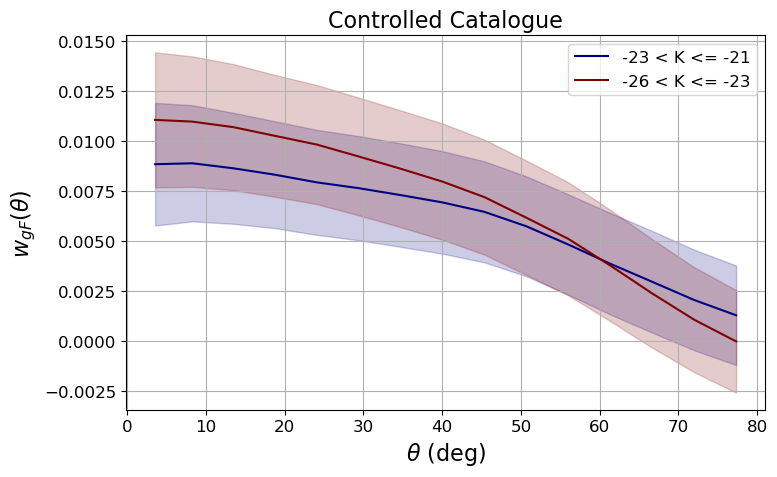

In [18]:
"""
CALCULATE CORRELATIONS FOR K SLICES WITH CZ CUT
"""
# === Load Galaxies ===
from astropy.io import ascii
gxs_file = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISEniBPT_control_SF_passive_cz_Kabs_ang5_cz1000.txt'
gxs = ascii.read(gxs_file)
gxs['M_Ks'] = gxs['K_abs']

k_slices = [(-21,-23), (-23,-26)]
colors_kslices = plt.cm.jet(np.linspace(0, 1, len(k_slices)))  # Color gradient

gxs_K = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 3600)]  # Apply cz cut to galaxy catalog

# === Load Flux map ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg', npatch=30)

# Generate random catalog
rand_ra, rand_dec = generate_RanCat(len(gxs_K)*10, dec_min=-90, dec_max=45)

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "num_bootstrap": 500,
    "cross_patch_weight": 'geom'
}

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 16,     # x/y labels
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})
#################
#################
# Plot K vs CZ
#################
#################
plt.scatter(gxs_K['cz'], gxs_K['M_Ks'], s=3, color='C0', alpha=0.5, label='K vs cz', facecolor='k')
for K in [item[0] for item in k_slices] + [k_slices[-1][1]]:
    print(K)
    plt.axhline(K, color='k', ls='--', lw=1)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('cz (km/s)')
plt.ylabel('K')
plt.title('Controlled Catalogue')
plt.show()

#################
#################
# Plot SkyMap
#################
#################
from matplotlib import colors

# === Plot ===
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

# Set ticks
xticks_deg = [270, 180, 90]
xticks_rad = -np.radians(xticks_deg) + np.pi
ax.set_xticks(xticks_rad)
ax.set_xticklabels([f"{d}°" for d in xticks_deg])

yticks_deg = [-75, -45, 0, 45, 75]
yticks_rad = np.radians(yticks_deg)
ax.set_yticks(yticks_rad)
ax.set_yticklabels([f"{d}°" for d in yticks_deg])

# === Flux Scatter plot (with horizontal colorbar below) ===
norm_flux = colors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
sc = ax.scatter(np.deg2rad(-flux_ra+180.), np.deg2rad(flux_dec), c=flux_val, s=5, cmap='coolwarm', norm=norm_flux)

# Horizontal colorbar for Flux
cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, fraction=0.05)
cbar_flux.set_label("Flux")

ax.scatter(np.deg2rad(-rand_ra+180.), np.deg2rad(rand_dec), s=1, color='k', label='Random points')
ax.scatter(np.deg2rad(-gxs_K['_RAJ2000']+180.), np.deg2rad(gxs_K['_DEJ2000']), s=10, color='C2', label='2MRS gxs')
plt.legend()
plt.title('Controlled Catalogue')
plt.show()

######################
######################
# Plot Correlations
######################
######################
fig, ax = plt.subplots(figsize=(8, 5))
for i, (k_max, k_min) in enumerate(k_slices):

    print('Processing slice:', k_min, k_max)

    # Filter galaxies for the current cz slice
    gxs_slice = gxs_K[(gxs_K['M_Ks'] > k_min) & (gxs_K['M_Ks'] <= k_max)]

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(ra=gxs_slice['_RAJ2000'], dec=gxs_slice['_DEJ2000'],
                                  ra_units='deg', dec_units='deg', npatch=30)
    rand_cat = treecorr.Catalog(ra=rand_ra[:len(gxs_slice)*10], dec=rand_dec[:len(gxs_slice)*10], 
                                ra_units='deg', dec_units='deg', patch_centers=gcat_slice.patch_centers)

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    #xi, varxi = nk.calculateXi(rk=rk)
    #xi = xi / flux_val.mean()  # Normalize by mean flux value

    # Pruebita
    xi = (nk.xi - flux_val.mean())  / flux_val.mean()  
    varxi = nk.varxi
    print(xi, varxi)
    #plt.errorbar(nk.meanr, xi, yerr=(varxi**.5), fmt='o-', color=colors_kslices[i])
    plt.fill_between(nk.meanr, xi - varxi**0.5, xi + varxi**0.5, 
                     color=colors_kslices[i], alpha=0.2)  # Add error band
    plt.plot(nk.meanr, xi, color=colors_kslices[i], label=f'{k_min} < K <= {k_max}')

# Finalize plot
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$w_{gF}(\theta)$')
ax.grid()
ax.legend(loc='upper right')
plt.title('Controlled Catalogue')
plt.tight_layout()
#plt.savefig('gal_flux_correlation.png', dpi=300)  # Save the figure
plt.show()

### Plot con el raw catalog
### Bootstrap artesanales (sólo bootstrapear galaxias)

/tmp/ipykernel_10328/1251932582.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978
-20
-21.5
-23
-27


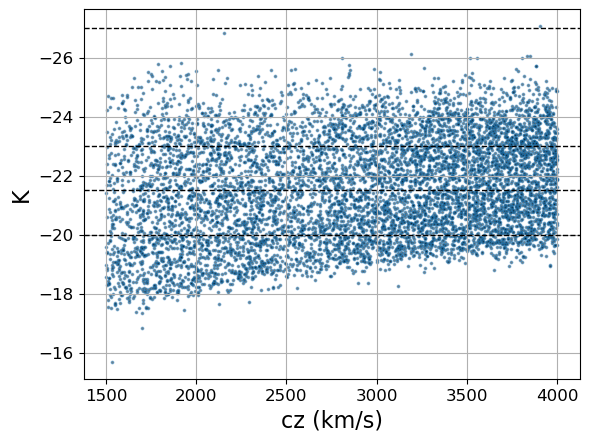

Processing slice: -21.5 -20
N. of galaxies in slice: 2172


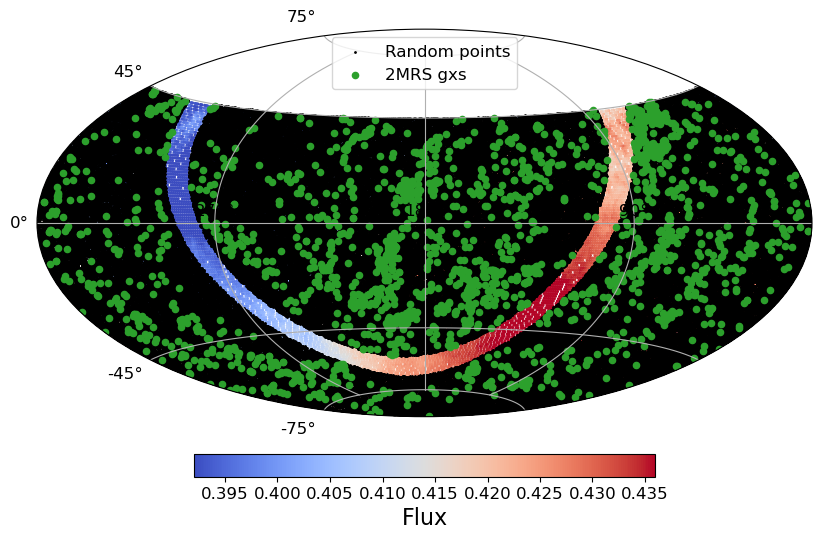

Processing slice: -22 -21.5
N. of galaxies in slice: 636


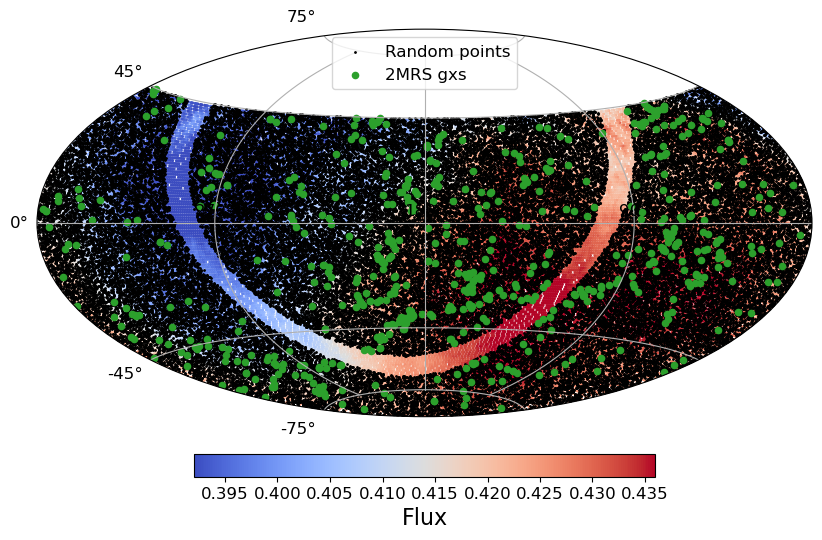

Processing slice: -27 -23
N. of galaxies in slice: 1805


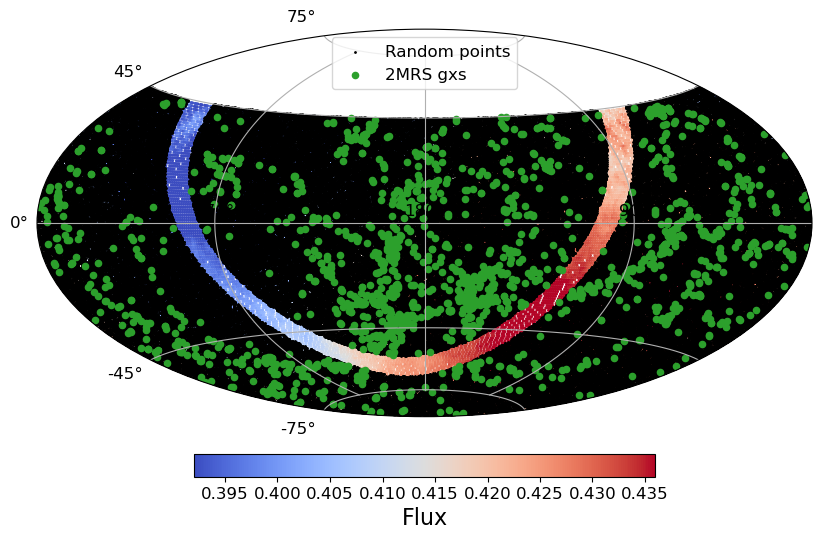

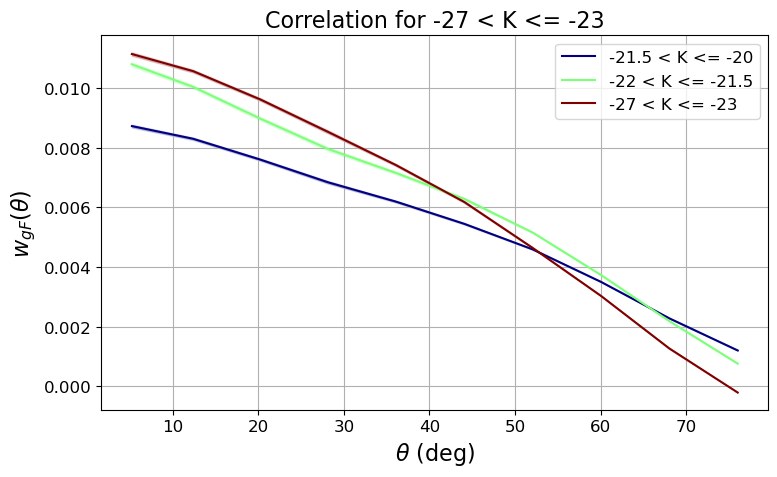

In [19]:
"""
CALCULATE CORRELATIONS FOR K SLICES WITH CZ CUT
"""
# === Load Galaxies ===
gxs = read_GLADE(cols)
k_slices = [(-20, -21.5), (-21.5, -22), (-23,-27)]
colors_kslices = plt.cm.jet(np.linspace(0, 1, len(k_slices)))  # Color gradient
nrand = 100

gxs_K = gxs[(gxs['cz'] >= 1500) & (gxs['cz'] <= 4000)]  # Apply cz cut to galaxy catalog

# === Load Flux map ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg')#, npatch=10)

# Generate random catalog for the current slice
rand_ra, rand_dec = generate_RanCat(len(gxs_K)*nrand, dec_min=-90, dec_max=45)

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 10,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    #"var_method": 'bootstrap',
    #"num_bootstrap": 500,
    "cross_patch_weight": 'geom'
}

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 16,     # x/y labels
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})
#################
#################
# Plot K vs CZ
#################
#################
plt.scatter(gxs_K['cz'], gxs_K['M_K'], s=3, color='C0', alpha=0.5, label='K vs cz', facecolor='k')
for K in [item[0] for item in k_slices] + [k_slices[-1][1]]:
    print(K)
    plt.axhline(K, color='k', ls='--', lw=1)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('cz (km/s)')
plt.ylabel('K')
#plt.title('Raw Catalogue')
plt.show()
plt.close()

from matplotlib import colors
def sky_plot(rand_ra, rand_dec, flux_ra, flux_dec, flux_val, gxs_K):

    # === Plot ===
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111, projection='hammer')
    ax.grid(True)

    # Set ticks
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels([f"{d}°" for d in xticks_deg])

    yticks_deg = [-75, -45, 0, 45, 75]
    yticks_rad = np.radians(yticks_deg)
    ax.set_yticks(yticks_rad)
    ax.set_yticklabels([f"{d}°" for d in yticks_deg])

    # === Flux Scatter plot (with horizontal colorbar below) ===
    norm_flux = colors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
    sc = ax.scatter(np.deg2rad(-flux_ra+180.), np.deg2rad(flux_dec), c=flux_val, s=5, cmap='coolwarm', norm=norm_flux, edgecolor='none')

    # Horizontal colorbar for Flux
    cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, fraction=0.05)
    cbar_flux.set_label("Flux")

    ax.scatter(np.deg2rad(-rand_ra+180.), np.deg2rad(rand_dec), s=1, color='k', label='Random points')
    ax.scatter(np.deg2rad(-gxs_K['RA']+180.), np.deg2rad(gxs_K['Dec']), \
               s=20, color='C2', label='2MRS gxs')
    plt.legend()
    #plt.title('Raw Catalogue')
    plt.show()
    plt.close()

# --- bootstrap variance function (uses same estimator and same rk) ---
def get_bootstrap_variance(gxs_slice, rand_cat, fcat, config, num_bootstrap=500, use_patches=False):
    nbins = config['nbins']
    xi_bs = np.zeros((num_bootstrap, nbins))

    if use_patches:
        # Example using healpix patch bootstrap (recommended if you care about spatial systematics)
        import healpy as hp
        nside = 16   # tune this (8,16,32) depending on patch size you want
        npix = hp.nside2npix(nside)
        # get pixel indices for galaxies
        theta = np.deg2rad(90. - gxs_slice['Dec'])
        phi = np.deg2rad(gxs_slice['RA'])
        gpix = hp.ang2pix(nside, theta, phi)
        patch_indices = [np.where(gpix == p)[0] for p in range(npix)]

        for i in range(num_bootstrap):
            sel_patches = np.random.randint(0, npix, size=npix)
            idxs = np.concatenate([patch_indices[p] for p in sel_patches if patch_indices[p].size>0])
            if idxs.size == 0:
                continue
            gbs = gxs_slice[idxs]

            gcat_bs = treecorr.Catalog(ra=gbs['RA'], dec=gbs['Dec'],
                                    ra_units='deg', dec_units='deg')
            nk_bs = treecorr.NKCorrelation(config)
            rk_bs = treecorr.NKCorrelation(config)
            nk_bs.process(gcat_bs, fcat)
            rk_bs.process(rand_cat, fcat)          # keep the same randoms (they describe geometry)
            xi_bs[i], _ = nk_bs.calculateXi(rk=rk_bs)
    else:
        # Simple iid bootstrap (fast, ok if spatial systematics are negligible)
        for i in range(num_bootstrap):
            sel = np.random.choice(len(gxs_slice), size=len(gxs_slice), replace=True)
            gbs = gxs_slice.iloc[sel]
            gcat_bs = treecorr.Catalog(ra=gbs['RA'], dec=gbs['Dec'],
                                    ra_units='deg', dec_units='deg')
            nk_bs = treecorr.NKCorrelation(config)
            rk_bs = treecorr.NKCorrelation(config)
            nk_bs.process(gcat_bs, fcat)
            rk_bs.process(rand_cat, fcat)
            xi_bs[i], _ = nk_bs.calculateXi(rk=rk_bs)

    return np.var(xi_bs, axis=0, ddof=1)

######################
######################
# Plot Correlations (separately for each K slice)
######################
######################

results = []  # store (meanr, xi, varxi, label) for each slice

for i, (k_max, k_min) in enumerate(k_slices):

    print('Processing slice:', k_min, k_max)

    # Filter galaxies for the current k slice
    gxs_slice = gxs_K[(gxs_K['M_K'] > k_min) & (gxs_K['M_K'] <= k_max)]
    print('N. of galaxies in slice:', len(gxs_slice))

    # Sky plot for this slice
    sky_plot(rand_ra[:len(gxs_slice)*nrand], rand_dec[:len(gxs_slice)*nrand],
             flux_ra, flux_dec, flux_val, gxs_slice)

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(
        ra=gxs_slice['RA'], dec=gxs_slice['Dec'],
        ra_units='deg', dec_units='deg'
    )
    rand_cat = treecorr.Catalog(
        ra=rand_ra[:len(gxs_slice)*nrand], dec=rand_dec[:len(gxs_slice)*nrand],
        ra_units='deg', dec_units='deg'
    )

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    xi, _ = nk.calculateXi(rk=rk)
    xi /= flux_val.mean()  # Normalize by mean flux

    # Bootstrap variance
    var_bs = get_bootstrap_variance(gxs_slice, rand_cat, fcat,
                                    config, num_bootstrap=20, use_patches=False)
    varxi = var_bs / (flux_val.mean()**2)

    # Store results for later plotting
    results.append((nk.meanr, xi, varxi, f'{k_min} < K <= {k_max}', colors_kslices[i]))

plt.figure(figsize=(8, 5))
# --- Plot each correlation separately ---
for meanr, xi, varxi, label, color in results:
    plt.fill_between(meanr, xi - (varxi**0.5), xi + (varxi**0.5),
                     color=color, alpha=0.2)
    plt.plot(meanr, xi, color=color, label=label)
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$w_{gF}(\theta)$')
plt.grid()
plt.legend(loc='upper right')
plt.title(f'Correlation for {label}')
plt.tight_layout()
plt.show()
